# Fast-forward NN

This NN takes a list of parts (frequency encoded) as input and should give valid graphs as output, which are given as a global adjacency matrix. By global I mean a matrix which is number_of_unique_parts x number_of_unique_parts.


PROBLEM: Model cannot be trained because there is not enough memory available on my laptop (RuntimeError: Invalid buffer size: 34.00 GB)

## Setup

In [1]:
import os
from collections import Counter
import torch
import time
import random
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from abc import ABC, abstractmethod
from typing import Set, List, Tuple
from graph_loader import load_graphs
from graph import Graph
from part import Part
from node import Node
from typing import Dict, List, Set, Tuple, Union

In [2]:
# MPS for Metal acceleration for Mac
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu") 
SEED = 0
random.seed(SEED)
# setgrad = lambda g, *ms: [setattr(p,'requires_grad', g) for m in ms for p in m.parameters() ]  

/var/folders/42/x47cnz7x2v98xvk5lhdybbnm0000gn/T/ipykernel_90474/966742386.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")


## Visualize

Some initial data exploration: create histograms for the occurences of family_ids, part_ids and nodes.

1621 0
1237 0
635 0
1621 0
802 0
118 0
531 0
1172 0
118 0
839 0
118 0
839 0
1124 0
1252 0
505 0
118 0
236 0
743 0
118 0
1886 0
0 0
118 0
505 0
738 0
1473 0
144 0
1316 0
118 0
663 0
1621 0
579 0
1696 0
118 0
2238 0
531 0
1166 0
505 0
413 0
504 0
193 0
1156 0
354 0
1839 0
172 0
418 0
259 0
181 0
1079 0
382 0
382 0
648 0
244 0
118 0
579 0
1109 0
245 0
848 0
259 0
505 0
848 0
118 0
431 0
118 0
663 0
623 0
325 0
236 0
721 0
531 0
118 0
1706 0
1166 0
287 0
1196 0
1402 0
663 0
413 0
1215 0
638 0
1402 0
382 0
1666 0
1166 0
118 0
118 0
181 0
1971 0
1191 0
663 0
1402 0
118 0
181 0
1218 0
118 0
742 0
781 0
118 0
181 0
259 0
118 0
1229 0
513 0
1316 0
492 0
930 0
382 0
552 0
278 0
421 0
1030 0
236 0
1738 0
663 0
325 0
118 0
618 0
494 0
181 0
118 0
1299 0
1839 0
181 0
0 0
118 0
673 0
1237 0
413 0
930 0
236 0
1666 0
839 0
172 0
414 0
1079 0
618 0
688 0
1216 0
1237 0
738 0
118 0
848 0
1394 0
181 0
264 0
1916 0
1836 0
509 0
506 0
1362 0
505 0
509 0
1196 0
1839 0
413 0
743 0
292 0
1222 0
509 0
839 0
118

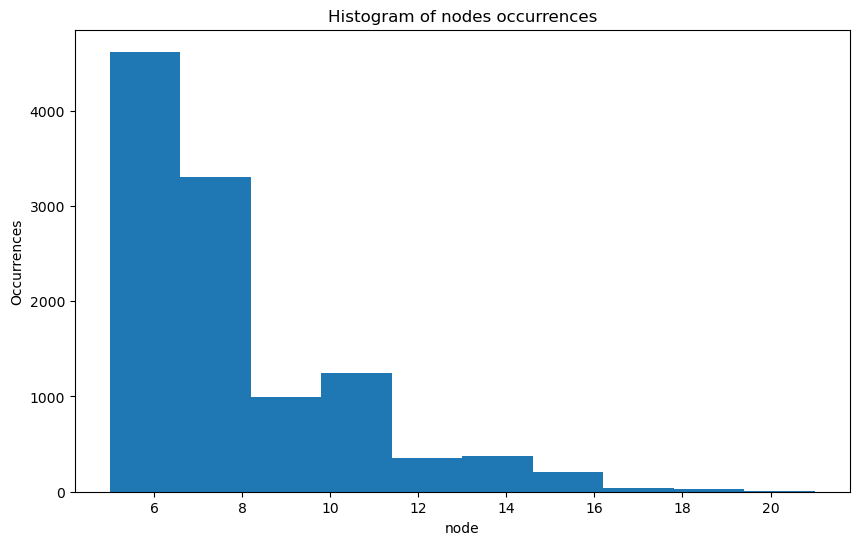

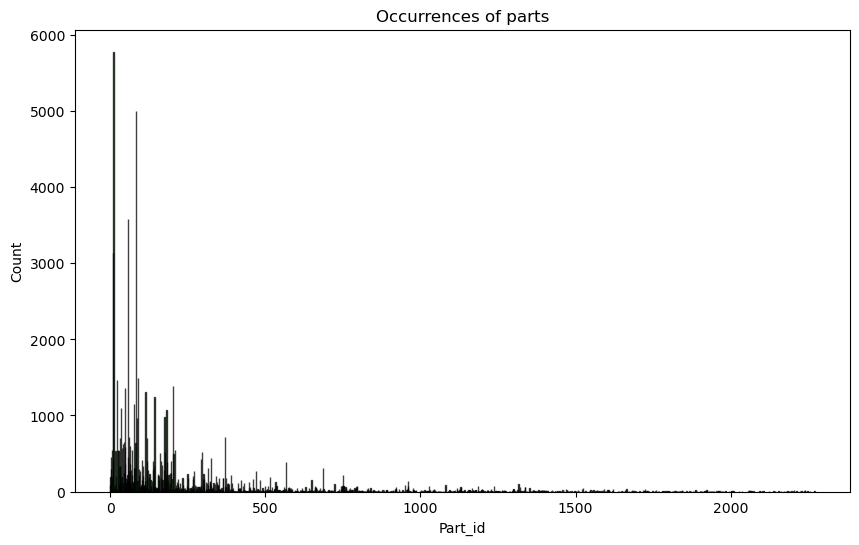

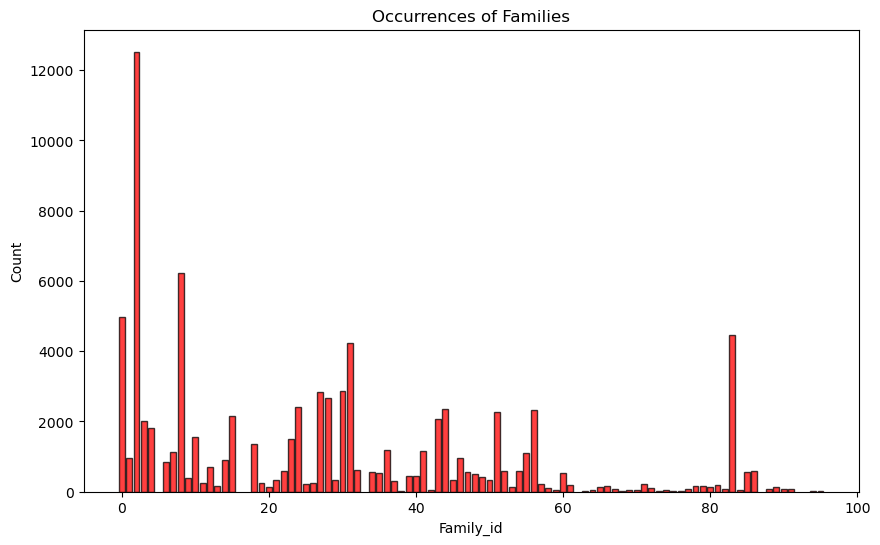

In [3]:
# descriptive analysis of the dataset
graphs = load_graphs("data/graphs.dat")
'''
graphs[0].draw()
print(graphs[0].get_parts())
print(graphs[0].get_nodes())
'''
number_of_graphs = len(graphs)
number_of_parts = 0
number_of_families = 0
number_of_connected_graphs = 0
number_of_cyclic_graphs = 0
number_of_nodes = []
part_id_counter = Counter()
family_id_counter = Counter()
node_id_counter = Counter()

part_set = set()



for graph in graphs:
    if graph.is_connected():
        number_of_connected_graphs += 1
    if graph.is_cyclic():
        number_of_cyclic_graphs += 1
    nodes = graph.get_nodes()
    parts = graph.get_parts()    
    number_of_nodes.append(len(nodes))
    for node in nodes:
        node_id_counter[node.get_id] += 1
    for part in parts:
        p_id = int(part.get_part_id())
        part_set.add(p_id)
        part_id_counter[p_id] += 1
        family_id_counter[int(part.get_family_id())] += 1
        if int(part.get_family_id()) == 0:
            print(p_id, part.get_family_id())
        number_of_parts += 1
        number_of_families += 1
    
# cannot use get_parts method because it returns a set of nodes
print(f"Number of graphs: {number_of_graphs}")
print(f"Number of parts: {number_of_parts}")
print(f"Number of distinct parts: {len(part_set)}")
# Get the smallest part_id
smallest_part_id = min(part_set)
print(f"The smallest part_id is: {smallest_part_id}")


print(f"Number of families: {number_of_families}")
print(f"Number of connected graphs: {number_of_connected_graphs}")
print(f"Number of cyclic graphs: {number_of_cyclic_graphs}")



# Convert the Counter dictionary into two lists:
part_ids, counts = zip(*part_id_counter.items())

plt.figure(figsize=(10, 6))
plt.hist(number_of_nodes)
plt.xlabel("node")
plt.ylabel("Occurrences")
plt.title("Histogram of nodes occurrences")
plt.show()


parts, counts = zip(*part_id_counter.items())
# Visualization: Bar chart
plt.figure(figsize=(10, 6))
plt.bar(parts, counts, alpha=0.75, color='green', edgecolor='black')
plt.title("Occurrences of parts")
plt.xlabel("Part_id")
plt.ylabel("Count")
plt.show()

family, counts = zip(*family_id_counter.items())
# Visualization: Bar chart
plt.figure(figsize=(10, 6))
plt.bar(family, counts, alpha=0.75, color='red', edgecolor='black')
plt.title("Occurrences of Families")
plt.xlabel("Family_id")
plt.ylabel("Count")
plt.show()


## Custom Dataset
We create custom datasets for train, validation and test.

In [4]:
class GraphDataset(Dataset):
    def __init__(self, file_path: str, train=False, validation=False, test=False, seed=42):
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Dataset file not found at {file_path}")

        self.graphs = load_graphs(file_path)

        if sum([train, validation, test]) != 1:
            raise ValueError("Exactly one of 'train', 'validation', or 'test' must be True.")


        # Create global mapping for unique parts
        self.family_part_dict = {}


        unique_parts = set()
        for graph in self.graphs:
            parts = graph.get_parts()
            for part in parts:
                unique_parts.add(int(part.get_part_id()))
                self.family_part_dict[int(part.get_part_id())] = int(part.get_family_id())

        # unique parts and mapping across all graphs (not just within a certain split)
        unique_parts = sorted(list(unique_parts))
        self.total_global_part_to_idx = {part: idx for idx, part in enumerate(unique_parts)} # mapping part_id to index
        self.idx_to_part_id = {idx: part for part, idx in self.total_global_part_to_idx.items()}  # Reverse mapping
        self.total_num_unique_parts = len(unique_parts)

        # Split: 70% training, 15% validation, 15% test
        train_graphs, test_graphs = train_test_split(self.graphs, test_size=0.3, random_state=seed)
        validation_graphs, test_graphs = train_test_split(test_graphs, test_size=0.5, random_state=seed)

        if train:
            self.graphs = train_graphs
        elif validation:
            self.graphs = validation_graphs
        elif test:
            self.graphs = test_graphs

        
    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Retrieves the parts and graph for the given index.
        :param idx: Index of the graph.
        :return: Tuple of (parts, graph).
        """
        graph = self.graphs[idx]
        
        # Initialize a count vector for parts
        part_frequency_vector = np.zeros(self.total_num_unique_parts, dtype=np.int32)

        # Count occurrences of each part
        parts = graph.get_parts()
        for part in parts:
            part_id = int(part.get_part_id())
            mapped_id = self.total_global_part_to_idx[part_id]
            part_frequency_vector[mapped_id] += 1  # Increment the count
        
        # Ensure part_features is 2D
        part_frequency_vector = torch.tensor(part_frequency_vector, dtype=torch.float).unsqueeze(-1)

        return part_frequency_vector, graph


    def graph_to_local_adjacency_matrix(self, graph):
        """
        Converts a graph to a local adjacency matrix.
        """
        parts = graph.get_parts()
        part_order = tuple(sorted(parts, key=lambda part: part.get_part_id()))
        adj_matrix = graph.get_adjacency_matrix(part_order)

        return adj_matrix
        

        
    def graph_to_global_adjacency_matrix(self, graph):
        """
        Converts a graph to a global adjacency matrix with a global part-to-index mapping.
        """
        # Determine the maximum part_id to size the adjacency matrix
        adj_matrix = np.zeros((self.total_num_unique_parts, self.total_num_unique_parts), dtype=int)

        edges: Dict[Node, List[Node]] = graph.get_edges()


        for node, connected_nodes in edges.items():
            part_id = int(node.get_part().get_part_id()) # cast str to int
            mapped_part_idx = self.total_global_part_to_idx[part_id]

            for connected_node in connected_nodes:
                connected_part_id = int(connected_node.get_part().get_part_id())
                mapped_connected_part_idx = self.total_global_part_to_idx[connected_part_id]

                # Update the adjacency matrix symmetrically
                adj_matrix[mapped_part_idx, mapped_connected_part_idx] = 1
                adj_matrix[mapped_connected_part_idx, mapped_part_idx] = 1

        return adj_matrix


    def graph_to_edge_list(self, graph):
        """
        Converts a graph to an edge list representation.
        Each edge is represented as a tuple (part_id, connected_part_id).
        """
        edge_list = []

        edges: Dict[Node, List[Node]] = graph.get_edges()

        for node, connected_nodes in edges.items():
            part_id = int(node.get_part().get_part_id())  # Ensure part_id is int
            mapped_part_idx = self.total_global_part_to_idx[part_id]


            for connected_node in connected_nodes:
                connected_part_id = int(connected_node.get_part().get_part_id())  # Ensure connected_part_id is int
                mapped_connected_part_idx = self.total_global_part_to_idx[connected_part_id]


                # Add the edge as a tuple (part_id, connected_part_id)
                # the same edge can occure more than once in the edge list because it can occur more than once in a graph
                edge_list.append((mapped_part_idx, mapped_connected_part_idx))
                edge_list.append((mapped_connected_part_idx, mapped_part_idx)) # --> for symmetry


        return edge_list


In [5]:
training_set = GraphDataset("data/graphs.dat", train = True, seed=SEED)
validation_set = GraphDataset("data/graphs.dat", validation = True, seed=SEED)
testing_set = GraphDataset("data/graphs.dat", test = True, seed=SEED)

## Model: Feedforward Neural Network

This NN takes a list of parts (frequency encoded) as input and should give valid graphs as output, which are given as a global adjacency matrix. By global I mean a matrix which is number_of_unique_parts x number_of_unique_parts.

In [6]:
import torch
import torch.nn as nn

class AdjacencyMatrixPredictor(nn.Module):
    def __init__(self, num_parts, hidden_dim):
        super(AdjacencyMatrixPredictor, self).__init__()
        self.fc1 = nn.Linear(num_parts, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_parts * num_parts)  # Output size is the flattened adjacency matrix
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))  # Predict edge probabilities

        # Compute number of parts
        batch_size = x.size(0)
        num_parts = int(x.size(1) ** 0.5)  # Assuming input is num_parts^2

        # Ensure output size matches expected adjacency matrix dimensions
        if num_parts * num_parts != x.size(1):
            raise ValueError(f"Output size {x.size(1)} does not match square of num_parts {num_parts}.")

        return x.view(batch_size, num_parts, num_parts)

    ''''
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))  # Predict edge probabilities
        return x.view(-1, x.size(1), x.size(1))  # Reshape into adjacency matrix form
    '''

In [7]:
def prepare_graph_data(graph_dataset):
    inputs = []
    targets = []

    for part_features, graph in graph_dataset:
        # Input: Frequency-encoded parts
        inputs.append(part_features.squeeze())  # Remove singleton dimension

        # Target: Global adjacency matrix
        adj_matrix = graph_dataset.graph_to_global_adjacency_matrix(graph)
        targets.append(torch.tensor(adj_matrix, dtype=torch.float))

    # Convert to tensors
    inputs = torch.stack(inputs)  # Shape: (num_graphs, num_parts)
    targets = torch.stack(targets)  # Shape: (num_graphs, num_parts, num_parts)
    return inputs, targets

In [8]:
# Prepare data
train_inputs, train_targets = prepare_graph_data(training_set)
val_inputs, val_targets = prepare_graph_data(validation_set)

# Define model, optimizer, and loss
num_parts = train_inputs.size(1)
model = AdjacencyMatrixPredictor(num_parts=num_parts, hidden_dim=128).to(device)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(train_inputs.to(device))  # Shape: (num_graphs, num_parts, num_parts)
    loss = criterion(predictions, train_targets.to(device))

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

RuntimeError: Invalid buffer size: 34.00 GB

## --> RuntimeError: Invalid buffer size: 34.00 GB
Training with batches did not help much either.

This means that the model cannot be trained and we save ourselves further code.